# TMA Training from features

- high-grade serous carcinoma (HGSC)
- clear-cell ovarian carcinoma (CC)
- endometrioid (EC)
- low-grade serous (LGSC)
- mucinous carcinoma. (MC)

Features extractor selected from this paper: https://arxiv.org/pdf/2311.11772.pdf
- Lunit-DINO_p16 ViTS

## Generated Data: Validated TMA (Tiles)
- Input images x20 TMA
- 25 real TMA resized to x20
- 23k, 36k (with and without augmentation)
- 81k (81118) plain + 53k (53601) stained + 23k (23922) = 158k (158641)

## Model
- Backbone: Lunit-DINO_p16
- AttentionMIL
- Cross Validation: 4 folds stratified by class + number of tiles
- Balanced Accuracy: Tiles OOF = 0.798, Images OOF = 0.862

In [2]:
import sys
sys.path.append("code/src")

In [3]:
import torch
import os
import random, math
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 280)
from PIL import Image
import cv2
import glob, json
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.utils.data as data
import wandb
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, average_precision_score, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, TimeSeriesSplit, KFold, GroupKFold, StratifiedGroupKFold
from scipy.special import softmax
import uuid

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=0.8)
from tqdm.auto import tqdm
from collections import OrderedDict

import pytorch_lightning as L
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks import StochasticWeightAveraging
from pytorch_lightning.callbacks import ModelPruning
from pytorch_lightning import seed_everything

# Apache2 license
from nemo.collections.common.callbacks.ema import EMA
from nemo.utils.callbacks.nemo_model_checkpoint import NeMoModelCheckpoint

from ubc.models.mil import UBCAttentionMILModel as UBCModel

from ubc.utils.imaging import *
from ubc.training.samplers import get_batch_sampler, get_sampler
from ubc.utils.torch import save_config, Config

from torchvision import transforms

import wandb
import timm

from skimage.exposure import match_histograms
torch.set_float32_matmul_precision('medium') # 'high'

print("Python", sys.version)
print("Numpy", np.__version__)
print("Pandas", pd.__version__)
print("Pytorch", torch.__version__)
print("Lightning", L.__version__)
print("Timm", timm.__version__)
print("Albumentations", A.__version__)
print("WandB", wandb.__version__)

Python 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
Numpy 1.26.2
Pandas 2.1.3
Pytorch 2.1.1+cu121
Lightning 2.1.2
Timm 0.9.10
Albumentations 1.3.1
WandB 0.16.0


In [4]:
DATA_HOME = "./data"
IMAGES_HOME = os.path.join(DATA_HOME, "images", "tma_x20_pyvips_TMA_FULL_1482_1694_0.5") # 155k
FEATURES_HOME = os.path.join(DATA_HOME, "features")
# Features extracted from tiles
RELATIVE_FOLDER = "tma_x20_pyvips_FULL_AND_MASK_TUMORAL_0.5_OTSU_0.8_0.1_80_AUG_Lunit-DINO-ViTS_p16_224"
RELATIVE_FOLDER_1 = "tma_x20_pyvips_TMA_FULL_1482_1694_0.5_Lunit-DINO-ViTS_p16_224_AUG_STAIN"
RELATIVE_FOLDER_2 = "tma_x20_pyvips_TMA_FULL_1482_1694_0.5_Lunit-DINO-ViTS_p16_224_AUG_NONE"
EXTERNAL_RELATIVE_FOLDER = None
TILES_FEATURES_HOME = os.path.join(FEATURES_HOME, RELATIVE_FOLDER)
TILES_FEATURES_HOME_1 = os.path.join(FEATURES_HOME, RELATIVE_FOLDER_1)
TILES_FEATURES_HOME_2 = os.path.join(FEATURES_HOME, RELATIVE_FOLDER_2)
EXTERNAL_TILES_FEATURES_HOME = os.path.join(FEATURES_HOME, EXTERNAL_RELATIVE_FOLDER) if EXTERNAL_RELATIVE_FOLDER is not None else None
TRAIN_FILE = os.path.join(DATA_HOME, "train.csv")
EXTERNAL_TRAIN_FILE = None
ITYPE = "tma" if "tma_" in RELATIVE_FOLDER else "wsi"
SEEDS = [67]
FOLDS = 4
VERSION = "v5.2.0"

OTHER = None # 5 # None
CLASSES_MAP = {
    'HGSC': 0,
    'LGSC': 1,
    'EC': 2,
    'CC': 3,
    'MC': 4,
}
if OTHER is not None:
    CLASSES_MAP["OTHER"] = OTHER

CLASSES_INVERSE_MAP = {v:k for k,v in CLASSES_MAP.items()}
CLASSES_MAP_LIST = [v for k,v in CLASSES_MAP.items()]
STAIN_REF_TILE = None

In [6]:
external_pd = None
# External data: TCGA
if EXTERNAL_TILES_FEATURES_HOME is not None:
    tcga_pd = pd.read_csv(EXTERNAL_TRAIN_FILE, sep=";")
    if OTHER is not None:
        tcga_pd = tcga_pd[tcga_pd["label"].isin(["0", "1", "5"])] # Keep HGCS, LGSC and OTHER
    else:
        tcga_pd = tcga_pd[tcga_pd["label"].isin(["0","1"])] # Keep HGCS, LGSC
    tcga_pd = tcga_pd[~tcga_pd["id"].isin(["TCGA-13-A5FT","TCGA-13-A5FU"])].reset_index(drop=True) # Remove x20 (others are x40)
    tcga_pd["label"] = tcga_pd["label"].apply(lambda x: int(x))
    tcga_pd["label"] = tcga_pd["label"].map(CLASSES_INVERSE_MAP)
    tcga_pd = tcga_pd.rename(columns={"id": "image_id"})
    tcga_id = tcga_pd["image_id"].unique()
    # len(tcga_id)    
    external_files = glob.glob(EXTERNAL_TILES_FEATURES_HOME + "/*/*.npz")
    external_files = [f for f in external_files if "thumbnail_" not in f]
    external_files = [f for f in external_files for i in tcga_id if i in f]
    external_pd = pd.DataFrame(external_files, columns=["image_file"])
    external_pd["image_id"] = external_pd["image_file"].apply(lambda x: "-".join(x.split("/")[-1].split("-")[0:3]) )
    external_pd = pd.merge(external_pd, tcga_pd, on="image_id", how='inner')
    external_pd["tiles"]  = external_pd["image_file"].apply(lambda x: int(x.split("_")[-1].replace(".npz", "")))
    external_pd["class"] = external_pd["label"].map(CLASSES_MAP)
    external_pd["is_tma"] = False
    external_pd["image_id"]	= external_pd["image_id"].apply(lambda x: uuid.uuid5(uuid.NAMESPACE_X500, x).int%10000000)
    external_pd["image_id"]	= external_pd["image_id"].astype(int)
    display(external_pd.describe())

In [8]:
files = glob.glob(TILES_FEATURES_HOME + "/*/*.npz") # [0:1000]
print(len(files))
files = [f for f in files  if "thumbnail_map.npz" not in f]
print(len(files))
files_1 = glob.glob(TILES_FEATURES_HOME_1 + "/*/*.npz") # [0:1000]
print(len(files_1))
files_1 = [f for f in files_1  if "thumbnail_map.npz" not in f]
print(len(files_1))
files_2 = glob.glob(TILES_FEATURES_HOME_2 + "/*/*.npz") # [0:1000]
print(len(files_2))
files_2 = [f for f in files_2  if "thumbnail_map.npz" not in f]
print(len(files_2))
files.extend(files_1)
files.extend(files_2)
tma_pd = pd.DataFrame(files, columns=["image_file"])
tma_pd["image_id"] = tma_pd["image_file"].apply(lambda x: int(x.split("/")[-2]))
tma_pd["tiles"] = tma_pd.groupby("image_id")["image_file"].transform('count')
train_pd = pd.read_csv(TRAIN_FILE)
train_pd["class"] = train_pd["label"].map(CLASSES_MAP)

train_pd = pd.merge(train_pd, tma_pd, on=["image_id"], how="inner")
if "WSI" in RELATIVE_FOLDER:
    train_pd["tiles"]  = train_pd["image_file"].apply(lambda x: int(x.split("_")[-1].replace(".npz", "")))
    if external_pd is not None:
        train_pd = pd.concat([train_pd, external_pd], ignore_index=True)
    TILE_BINS = 3 # 3
    train_pd["tiles_bin"] = pd.cut(train_pd["tiles"], bins=TILE_BINS, labels=list(range(TILE_BINS)))    
else:
    TILE_BINS = [0, 39, 2000] # 2
    TILE_BINS = [0, 50, 65, 82, 101, 122, 145, 170] # 2
    train_pd["tiles_bin"] = pd.cut(train_pd["tiles"], bins=TILE_BINS, labels=list(range(len(TILE_BINS)-1)))
print(train_pd.shape)
train_pd.head()

23922
23922
53601
53601
81118
81118
(158641, 9)


,image_id,label,image_width,image_height,is_tma,class,image_file,tiles,tiles_bin
0,4,HGSC,23785,20008,False,0,./data/features/tma_x20_pyvips_FULL_AND_MASK_TUMORAL_0.5_OTSU_0.8_0.1_80_AUG_Lunit-DINO-ViTS_p16_224/4/4_0_49.npz,29,0
1,4,HGSC,23785,20008,False,0,./data/features/tma_x20_pyvips_FULL_AND_MASK_TUMORAL_0.5_OTSU_0.8_0.1_80_AUG_Lunit-DINO-ViTS_p16_224/4/4_13_64.npz,29,0
2,4,HGSC,23785,20008,False,0,./data/features/tma_x20_pyvips_FULL_AND_MASK_TUMORAL_0.5_OTSU_0.8_0.1_80_AUG_Lunit-DINO-ViTS_p16_224/4/4_14_100.npz,29,0
3,4,HGSC,23785,20008,False,0,./data/features/tma_x20_pyvips_FULL_AND_MASK_TUMORAL_0.5_OTSU_0.8_0.1_80_AUG_Lunit-DINO-ViTS_p16_224/4/4_15_100.npz,29,0
4,4,HGSC,23785,20008,False,0,./data/features/tma_x20_pyvips_FULL_AND_MASK_TUMORAL_0.5_OTSU_0.8_0.1_80_AUG_Lunit-DINO-ViTS_p16_224/4/4_16_121.npz,29,0


In [9]:
train_pd["tiles"].sum(), train_pd["image_id"].nunique()

(79101789, 537)

Seed set to 67


67 0 (118919, 9) (39722, 9) 402 135 []
67 1 (118717, 10) (39924, 10) 408 129 []
67 2 (118746, 10) (39895, 10) 404 133 []
67 3 (119541, 10) (39100, 10) 397 140 []


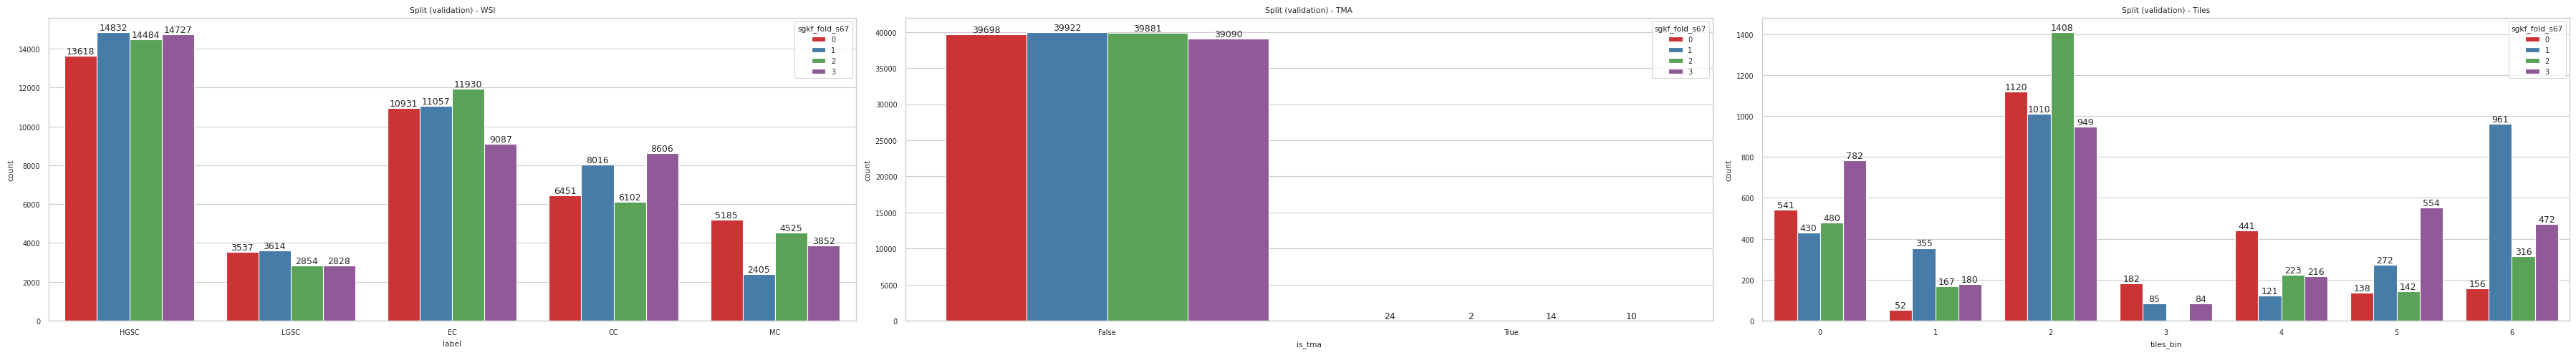

,image_id,label,image_width,image_height,is_tma,class,image_file,tiles,tiles_bin,sgkf_fold_s67
0,4,HGSC,23785,20008,False,0,./data/features/tma_x20_pyvips_FULL_AND_MASK_TUMORAL_0.5_OTSU_0.8_0.1_80_AUG_Lunit-DINO-ViTS_p16_224/4/4_0_49.npz,29,0,3
1,4,HGSC,23785,20008,False,0,./data/features/tma_x20_pyvips_FULL_AND_MASK_TUMORAL_0.5_OTSU_0.8_0.1_80_AUG_Lunit-DINO-ViTS_p16_224/4/4_13_64.npz,29,0,3
2,4,HGSC,23785,20008,False,0,./data/features/tma_x20_pyvips_FULL_AND_MASK_TUMORAL_0.5_OTSU_0.8_0.1_80_AUG_Lunit-DINO-ViTS_p16_224/4/4_14_100.npz,29,0,3
3,4,HGSC,23785,20008,False,0,./data/features/tma_x20_pyvips_FULL_AND_MASK_TUMORAL_0.5_OTSU_0.8_0.1_80_AUG_Lunit-DINO-ViTS_p16_224/4/4_15_100.npz,29,0,3
4,4,HGSC,23785,20008,False,0,./data/features/tma_x20_pyvips_FULL_AND_MASK_TUMORAL_0.5_OTSU_0.8_0.1_80_AUG_Lunit-DINO-ViTS_p16_224/4/4_16_121.npz,29,0,3


In [10]:
strat_cols = ["tiles_bin"]
stratify = train_pd["class"].astype(str)

for col in strat_cols:
    stratify += "_" + train_pd[col].astype(str)

for seed_ in SEEDS:
    seed_everything(seed_)
    kf = StratifiedGroupKFold(shuffle=True, random_state=seed_, n_splits=FOLDS)
    graphs = []
    
    for fold, (idx_tr, idx_va) in enumerate(kf.split(X=train_pd, y=stratify, groups=train_pd["image_id"])):
        X_tr, X_va = train_pd.loc[idx_tr], train_pd.loc[idx_va]      
        print(seed_, fold, X_tr.shape, X_va.shape,
              X_tr["image_id"].nunique(), X_va["image_id"].nunique(),
              np.intersect1d(X_tr["image_id"].values, X_va["image_id"].values))
        train_pd.loc[idx_va, "sgkf_fold_s%d" % seed_] = fold
            
    train_pd["sgkf_fold_s%d" % seed_] = train_pd["sgkf_fold_s%d" % seed_].astype(np.int16)
    
    fig, ax = plt.subplots(1, 3, figsize=(36,5))
    d = sns.countplot(x="label", data=train_pd, hue="sgkf_fold_s%d" % seed_, ax=ax[0], palette = "Set1")
    for i in ax[0].containers:
        ax[0].bar_label(i,fmt='%d', fontsize=9)
    ax[0].set_title("Split (validation) - WSI")
    d = sns.countplot(x="is_tma", data=train_pd, hue="sgkf_fold_s%d" % seed_, ax=ax[1], palette = "Set1")
    for i in ax[1].containers:
        ax[1].bar_label(i,fmt='%d', fontsize=9)
    ax[1].set_title("Split (validation) - TMA")
    d = sns.countplot(x="tiles_bin", data=train_pd, hue="sgkf_fold_s%d" % seed_, ax=ax[2], palette = "Set1")
    for i in ax[2].containers:
        ax[2].bar_label(i,fmt='%d', fontsize=9)
    ax[2].set_title("Split (validation) - Tiles")    
    
    # plt.legend()
    plt.tight_layout()
    plt.show()
      
    print()

train_pd.to_parquet(os.path.join(DATA_HOME, "train_%s_with_%dfolds_%s.parquet" % (ITYPE, FOLDS, VERSION)), index=False)
train_pd.head()

In [11]:
train_pd[train_pd["tiles"] > 1].describe()

,image_id,image_width,image_height,class,tiles,sgkf_fold_s67
count,158639.000000,158639.000000,158639.000000,158639.000000,158639.000000,158639.000000
mean,32115.224541,53063.235428,33240.044226,1.577361,498.627620,1.494040
std,18070.858747,16823.187550,8666.454055,1.393799,259.323248,1.115207
min,4.000000,2964.000000,2964.000000,0.000000,2.000000,0.000000
25%,16064.000000,39991.000000,26909.000000,0.000000,343.000000,0.000000
50%,35754.000000,51720.000000,32951.000000,2.000000,463.000000,1.000000
75%,46444.000000,66247.000000,39867.000000,3.000000,628.000000,2.000000
max,65533.000000,105763.000000,50155.000000,4.000000,1548.000000,3.000000


In [12]:
seed_ = SEEDS[0]
images_pd = train_pd.groupby("image_id")[["image_width", "image_height", "label", "is_tma", "class", "tiles", "sgkf_fold_s%d"%SEEDS[0]]].first().reset_index()
images_pd

,image_id,image_width,image_height,label,is_tma,class,tiles,sgkf_fold_s67
0,4,23785,20008,HGSC,False,0,29,3
1,66,48871,48195,LGSC,False,1,467,3
2,91,3388,3388,HGSC,True,0,2,0
3,281,42309,15545,LGSC,False,1,14,2
4,286,37204,30020,EC,False,2,434,2
...,...,...,...,...,...,...,...,...
532,65022,53355,46675,LGSC,False,1,516,3
533,65094,55042,45080,MC,False,4,80,1
534,65300,75860,27503,HGSC,False,0,80,3
535,65371,42551,41800,HGSC,False,0,80,3


In [15]:
from typing import Union, Optional, Sequence, Mapping, Any

def pad(x: np.ndarray, size: int, axis: int, fill_value: Any = 0):
    """Pad an array with zeros to a given size along a given axis"""
    if x.shape[axis] >= size:
        return x
    pad_width = [(0, 0)] * len(x.shape)
    pad_width[axis] = (0, size - x.shape[axis])
    return np.pad(x, pad_width=pad_width, mode="constant", constant_values=fill_value)


class Dataset(torch.utils.data.Dataset):

    def __init__(self, data_path, df, conf, subset='train', preprocess=None, augment=None, prepare=None):
        self.data_path = data_path
        self.df = df
        self.conf = conf
        self.subset = subset
        self.preprocess = preprocess
        self.augment = augment
        self.prepare = prepare

        self.margins = None
        if (self.subset == 'train') and (self.conf.loss_module == "subcenter_arcfaceadaptivemargin"):
            tmp = np.sqrt(1 / np.sqrt(self.df["class"].value_counts().sort_index().values))
            self.margins = (tmp - tmp.min()) / (tmp.max() - tmp.min()) * self.conf.loss_module_arcface_m_x + self.conf.loss_module_arcface_m_y
            self.margins = list(self.margins)
    
    def read_image_(self, record_id):
        with open(record_id, "rb") as f:
            img = np.load(f)["features"]
        return img

    def read_image(self, row):
        record_id = row["image_file"]
        return self.read_image_(record_id)
    

    def get_data(self, row, idx):
        img = self.read_image(row)

        sample = {
            'image': img,
            'weight': 1,
            "uid": row["image_id"],
        }

        # Optional preprocessing on RGB image (float)
        if self.preprocess:
            tmp = self.preprocess(image=sample['image'])
            sample['image'] = tmp["image"]  # Apply on full image

        # Optional augmentation on RGB image (float)
        if self.augment:
            tmp = self.augment(image=sample['image'])
            sample['image'] = tmp["image"]  # Apply on full image

        # Mandatory to feed model (normalization, convert to CHW)
        if (self.prepare) and (sample.get('image') is not None):
            tmp = self.prepare(image=sample['image'])
            sample['image'] = tmp["image"]  # Apply on full image

        sample["label"] = None
        if self.subset != "test":
            class_ = int(row["class"])
            label = np.zeros(self.conf.num_classes, dtype=np.float32)
            label[class_] = 1.
            sample["label"] = label

        feats = sample['image']
        labels = sample["label"]
        patient_ids = sample["uid"]

        return feats, labels, patient_ids

    def __len__(self):
        return len(self.df)

    def collate_fn(self, batch):
        """Collate a batch of features into a single tensor"""
        feats, labels, patient_ids = zip(*batch) # (BS, N_TILES, FEATURES), (BS, N_CLASSES), (BS, 1)    
        n_per_instance = [f.shape[0] for f in feats]
        n_max = max(n_per_instance)
        feats = np.stack([pad(f, n_max, axis=0) for f in feats])
        labels = np.stack([l for l in labels]) if labels[0] is not None else None
        patient_ids = np.stack([l for l in patient_ids])
        mask = torch.arange(n_max) < torch.tensor(n_per_instance).unsqueeze(-1)
        return (
            torch.from_numpy(feats).float(),
            mask,
            torch.from_numpy(labels).float() if labels is not None else None,
            torch.from_numpy(patient_ids).long()
        )
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        row = self.df.iloc[idx]
        sample = self.get_data(row, idx)
        return sample

In [16]:
# Some previews with augmentation
def display_preview(data_path, df, config, preprocess=None, augment=None, sampler=None, ROWS=20, COLS=3, max_batches=10, subset="train"):
    tmp_dataset = Dataset(data_path, df, config, subset=subset, preprocess=preprocess, augment=augment, prepare=None)
    print("tmp_dataset:", len(tmp_dataset))
    # print("Augmentation:", augment)
    tmp_sampler = None # get_sampler(config.sampler, ds=tmp_dataset)
    # print("Sampler:", tmp_sampler)    
    tmp_batch_sampler = get_batch_sampler(config, ds=tmp_dataset, debug=True)
    print("Batch sampler", tmp_batch_sampler)   
    
    tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size=config.batch_size if tmp_batch_sampler is None else 1, num_workers=0, drop_last=False, pin_memory=False, sampler=tmp_sampler, batch_sampler=tmp_batch_sampler, shuffle=False) #
    print("Loading")
    i = 0
    for tmp_batch in tmp_loader:
        images, labels, records = tmp_batch
        print(images.shape) if i == 0 else None

        k = 0
        K = 8
        labels_dict = {}
        
        for j, (img, label, record) in enumerate(zip(images, labels, records)):
            label = torch.argmax(label).item()
            labels_dict[label] = labels_dict[label] + 1 if labels_dict.get(label) is not None else 1
            if j == 0:
                print(img.shape, img.dtype, img.min(), img.max(), img.float().mean(), label, "uid", record)
            
            if k == 0:
                fig, ax = plt.subplots(1, K, figsize=(24, 5))
            
            d = ax[k].imshow(img.numpy())
            d = ax[k].set_title("%s: %s" % (record, label))
            d = ax[k].grid(False)
            k = k + 1
            
            if k == K:
                plt.tight_layout()
                plt.show()
                k = 0
                            
        print("labels_dict:", OrderedDict(sorted(labels_dict.items())))
        i = i + 1
        if i >= ROWS: break

In [17]:
class Config:
    
    version = "5.2.0"
    
    # Parameters
    seed = SEEDS[0]
    folds = FOLDS
    folds_seed = SEEDS[0]

    # Input image
    tma_size = (1568, 1568)
    imgsz = 224
    ar = -1
    center_crop = None
    crop_ratio = None
    
    # Backbone
    backbone = "lunitdino-vitsp16"
    global_pool = 'avg'       
    num_classes = len(CLASSES_MAP)
    # Pretrain
    pretrained = True
    max_pixel = None
    IMG_MEAN = None
    IMG_STD = None

    # Mask support
    mil = {
        "d_features": 384,
        "hidden_dim": 512,
        "batchnorm": False
    }
 
    # ArcFace module
    loss_module = "" # "subcenter_arcfaceadaptivemargin"
    # Adaptive Marging
    loss_module_margins = None # m is setup dynamically with training dataset    
    loss_module_arcface_m_x = 0.45
    loss_module_arcface_m_y = 0.05    
    loss_module_cosine_scale = 20 # (20 to 70) # s
    loss_module_k = 3
    fc_dim = mil["hidden_dim"]
    
    # Training
    epochs = 32
    batch_size = 32
    instances_per_bag = 49
    val_batch_size = batch_size
    accumulate_grad_batches = 4 if batch_size == 1 else 1
    gradient_clip_val = None
    
    # Stain
    stain = STAIN_REF_TILE # None
    stain_method = None
    stain_luminosity = False # True # False
    
    # Additional augmentations
    # Cut mix: Crop rectangle from another image in batch and paste it in image
    cutmix_prob = None # 0.5 # None
    cutmix_alpha = 1.0 
    # Mix 2 images within the same batch, try to improve generalization and reduce overfitting
    mixup_prob = None # 0.5 # 0.5 # None
    mixup_alpha = 0.2 # 1.0 # 0.2
    # Simulate TMA from tile
    tma_augmentation_train = None # 1.0 # 0.10 # 0.45 # None
    
    optimizer = 'AdamW' # 'AdaBound' # 'AdamW'
    # You should decrease the learning rate by the square root of the increase in batch size. For example, if you increase the batch size by 4, you should decrease the learning rate by 2
    lr0 = 1e-3 # 5e-4 # 1e-4 if ("vit" in backbone) or ("coat" in backbone) or ("swin" in backbone) or ("dei" in backbone) else 1e-3 # 3e-5
    lrf = 0.0
    scheduler = "cos_lr" # "lw_cos_lr" # "cos_lr"
    warmup_epochs = 0 # 2
    
    # Generalization
    dropout = 0.0
    # https://github.com/hoya012/swa-tutorials-pytorch
    swa_lrs = None # 2e-4 # 1e-4 # 3e-5 # 1e-2 # None # Must be higher than lrf
    # https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/core/exp_manager.html
    # https://github.com/NVIDIA/NeMo/blob/main/nemo/collections/common/callbacks/ema.py
    ema = 0.999 # 0.999 # None
    save_top_k = 5
    
    # Regularization
    label_smoothing=0.0 # Prevent overconfidence in label
    
    # Samplers
    sampler = None # "ImbalancedDatasetSampler" # None # "ImbalancedDatasetSampler"
    batch_sampler = "random" # "random" # fixed" # "fixed" # "random" # "fixed" # None "random"
    batch_sampler_alpha = 1.0 # 0.25
    
    # Hardware
    precision = "16-mixed" # "16"
    device = "gpu" # "gpu"
    deterministic = True
    num_workers = 6
    pruning = None

In [18]:
config = Config
seed_everything(config.seed, workers=True)

wandb_project = "TMA-V10"
models_home = "./models"
full_train = False
exclude_noisy = []
resume_fold = 0
train_home = IMAGES_HOME
save_weights_only = True
stage = "stage1"

preprocess_image = None
image_augmentation_train = None
prepare_feed = None

Seed set to 67


In [ ]:
for fold_ in range(config.folds):
    if fold_ < resume_fold:
        continue

    x_valid = train_pd[train_pd["sgkf_fold_s%d" % config.folds_seed] == fold_]
    x_train = train_pd[train_pd["sgkf_fold_s%d" % config.folds_seed] != fold_]
    x_valid_cleaned = x_valid
    x_train_cleaned = x_train        
    print("Valid/Train:", x_valid_cleaned.shape, x_train_cleaned.shape)

    train_dataset = Dataset(train_home, x_train_cleaned, config, subset="train", preprocess=preprocess_image,
                            augment=image_augmentation_train, prepare=prepare_feed)
    valid_dataset = Dataset(train_home, x_valid_cleaned, config, subset="valid", preprocess=preprocess_image,
                            augment=None, prepare=prepare_feed)

    train_sampler = get_sampler(config.sampler, ds=train_dataset)
    print("Train sampler", train_sampler)

    train_batch_sampler = get_batch_sampler(config, ds=train_dataset)
    print("Train batch sampler", train_batch_sampler)

    config.loss_module_margins = train_dataset.margins
    print("Train loss margins", config.loss_module_margins)

    train_dataloader = data.DataLoader(train_dataset,
                                       batch_size=config.batch_size if train_batch_sampler is None else 1,
                                       sampler=train_sampler, batch_sampler=train_batch_sampler, drop_last=False,
                                       num_workers=config.num_workers, shuffle=True if (
                    (train_sampler is None) and (train_batch_sampler is None)) else False, pin_memory=True, collate_fn=train_dataset.collate_fn)
    valid_dataloader = data.DataLoader(valid_dataset, batch_size=config.val_batch_size, drop_last=False,
                                       num_workers=config.num_workers, pin_memory=True, collate_fn=valid_dataset.collate_fn)

    model = UBCModel(config)

    model_path = "classifier_%s_%s_%s/seed%s/%s/%s" % (
    config.imgsz, config.backbone, config.version, config.seed, "fold%d" % fold_, stage)
            
    default_root_dir = os.path.join(models_home, model_path)
    os.makedirs(default_root_dir, exist_ok=True)
    d = save_config(config, os.path.join(default_root_dir, "config.json"))

    logger_wandb = None
    if wandb_project is not None:
        logger_wandb = WandbLogger(project=wandb_project, name=model_path.replace("/", "_"))
    logger_csv = CSVLogger("./logs", name=model_path.replace("/", "_"))

    lr_monitor = LearningRateMonitor(logging_interval='epoch')
    checkpoint_callback = ModelCheckpoint(dirpath=default_root_dir, monitor="val_balanced_accuracy", mode='max',
                                          filename='best_{epoch}-{val_balanced_accuracy:.4f}', save_top_k=config.save_top_k,
                                          save_last=True, save_weights_only=save_weights_only) 

    callbacks = [lr_monitor]

    if config.ema is not None:
        print("EMA enabled:", config.ema)
        ema = EMA(config.ema)
        callbacks.extend([ema])
        checkpoint_callback = NeMoModelCheckpoint(dirpath=default_root_dir, monitor="val_balanced_accuracy", mode='max',
                                                  filename='best_{epoch}-{val_balanced_accuracy:.4f}',
                                                  save_top_k=config.save_top_k, save_last=True,
                                                  save_nemo_on_train_end=False, save_weights_only=save_weights_only)

    callbacks.extend([checkpoint_callback])

    if config.swa_lrs is not None:
        print("SWA enabled")
        swa = StochasticWeightAveraging(swa_lrs=config.swa_lrs)
        callbacks.extend([swa])

    print()
    trainer = L.Trainer(
        default_root_dir = default_root_dir,
        max_epochs = config.epochs,
        accelerator = config.device,
        accumulate_grad_batches = config.accumulate_grad_batches,
        gradient_clip_val = config.gradient_clip_val,
        deterministic = config.deterministic,
        precision = config.precision,
        logger=logger_wandb if logger_wandb is not None else logger_csv,
        callbacks = callbacks,
        check_val_every_n_epoch = 1,
        enable_progress_bar = True
    )

    trainer.fit(model, train_dataloader, valid_dataloader, ckpt_path=None)

    if logger_wandb is not None:
        wandb.finish()

    # break

## OOF: Tiles level

In [ ]:
class Config:
    def __init__(self, dic):
        for k, v in dic.items():
            setattr(self, k, v)
            
preds, uids = [], []
resume_fold = 0
for fold_ in range(config.folds):
    if fold_ < resume_fold:
        continue
    x_valid = train_pd[train_pd["sgkf_fold_s%d" % config.folds_seed] == fold_]
    x_valid_cleaned = x_valid
    print("Tiles OOF", x_valid.shape, x_valid_cleaned.shape)
    
    test_dataset = Dataset(train_home, x_valid, config, subset="test", preprocess=None, augment=None, prepare=None)    
    test_dataloader = data.DataLoader(test_dataset, batch_size=1, drop_last=False, num_workers=config.num_workers, pin_memory=True, shuffle=False, collate_fn=test_dataset.collate_fn)    
        
    model_path = "classifier_%s_%s_%s/seed%s/%s/%s" % (config.imgsz, config.backbone, config.version, config.seed, "fold%d"%fold_, "stage1")    
    default_root_dir=os.path.join(models_home, model_path)    
        
    CLS_TTA = False 
    CHK = "best"
    pattern="%s_*-EMA.ckpt"%CHK if config.ema is not None else "%s_*.ckpt"%CHK
    # Load best checkpoint
    checkpoints = pd.DataFrame(glob.glob(os.path.join(default_root_dir, pattern)), columns=["checkpoint"])
    checkpoints["score"] = checkpoints["checkpoint"].apply(lambda x: float(x.split("=")[-1].split(".ckpt")[0].replace("-EMA", "")))
    weights = checkpoints.sort_values(["score"], ascending=[False])["checkpoint"].values[0]    
        
    print("Loading:", weights)
    if os.path.exists(weights):
        config = Config(json.load(open(os.path.join(default_root_dir, "config.json"), "r")))
        config.device = "cuda"
        model = UBCModel(config)
        model_dump = torch.load(weights, map_location=torch.device(config.device))
        model.load_state_dict(model_dump["state_dict"])                
        model.eval()        
        trainer = L.Trainer()
        predictions = trainer.predict(model, dataloaders=test_dataloader) 
        uids = x_valid["image_file"].values
        for uid, topk, logit, topk_prob in zip(uids, torch.stack([p[0] for p in predictions]).numpy().squeeze(), 
                                                torch.stack([p[1] for p in predictions]).numpy().squeeze(), 
                                                torch.stack([p[2] for p in predictions]).numpy().squeeze()):
            preds.append((uid, topk, logit, topk_prob))        
        
    # break

In [25]:
preds_pd = pd.DataFrame(preds, columns=["image_file", "oof_class", "oof_logits", "oof_prob"])
tiles_oof_pd = pd.merge(train_pd, preds_pd, on="image_file", how="inner")
tiles_oof_pd.to_parquet(os.path.join(default_root_dir, "oof_%s%s.parquet" % (CHK, "_tta" if CLS_TTA == True else "")))
tiles_oof_pd

,image_id,label,image_width,image_height,is_tma,class,image_file,tiles,tiles_bin,sgkf_fold_s67,oof_class,oof_logits,oof_prob
0,4,HGSC,23785,20008,False,0,./data/features/tma_x20_pyvips_FULL_AND_MASK_TUMORAL_0.5_OTSU_0.8_0.1_80_AUG_Lunit-DINO-ViTS_p16_224/4/4_0_49.npz,29,0,3,0,"[3.9883409, -0.80869746, 2.662446, -5.1160007, -7.521279]",0.784966
1,4,HGSC,23785,20008,False,0,./data/features/tma_x20_pyvips_FULL_AND_MASK_TUMORAL_0.5_OTSU_0.8_0.1_80_AUG_Lunit-DINO-ViTS_p16_224/4/4_13_64.npz,29,0,3,1,"[0.2201612, 0.5642221, -0.00047948398, -2.0942829, -2.9485075]",0.420648
2,4,HGSC,23785,20008,False,0,./data/features/tma_x20_pyvips_FULL_AND_MASK_TUMORAL_0.5_OTSU_0.8_0.1_80_AUG_Lunit-DINO-ViTS_p16_224/4/4_14_100.npz,29,0,3,0,"[2.5828102, 0.9865389, -0.57640195, -3.2868762, -5.7593427]",0.801172
3,4,HGSC,23785,20008,False,0,./data/features/tma_x20_pyvips_FULL_AND_MASK_TUMORAL_0.5_OTSU_0.8_0.1_80_AUG_Lunit-DINO-ViTS_p16_224/4/4_15_100.npz,29,0,3,0,"[2.684203, 0.9022468, -1.4340602, -3.1827238, -4.5819335]",0.841672
4,4,HGSC,23785,20008,False,0,./data/features/tma_x20_pyvips_FULL_AND_MASK_TUMORAL_0.5_OTSU_0.8_0.1_80_AUG_Lunit-DINO-ViTS_p16_224/4/4_16_121.npz,29,0,3,0,"[1.869806, -0.07638208, -0.2539, -2.2275245, -4.7873883]",0.781063
...,...,...,...,...,...,...,...,...,...,...,...,...,...
158636,65533,HGSC,45190,33980,False,0,./data/features/tma_x20_pyvips_TMA_FULL_1482_1694_0.5_Lunit-DINO-ViTS_p16_224_AUG_NONE/65533/65533_96_49.npz,726,NaN,3,0,"[1.0813414, -5.6603265, -0.023775233, -1.3218547, 0.761836]",0.465270
158637,65533,HGSC,45190,33980,False,0,./data/features/tma_x20_pyvips_TMA_FULL_1482_1694_0.5_Lunit-DINO-ViTS_p16_224_AUG_NONE/65533/65533_97_49.npz,726,NaN,3,0,"[2.9501898, -5.6085596, 1.8707219, -4.587541, -1.2012423]",0.737331
158638,65533,HGSC,45190,33980,False,0,./data/features/tma_x20_pyvips_TMA_FULL_1482_1694_0.5_Lunit-DINO-ViTS_p16_224_AUG_NONE/65533/65533_98_64.npz,726,NaN,3,3,"[-1.1536856, -1.8741161, -1.12229, 1.9347483, -0.7225333]",0.843944
158639,65533,HGSC,45190,33980,False,0,./data/features/tma_x20_pyvips_TMA_FULL_1482_1694_0.5_Lunit-DINO-ViTS_p16_224_AUG_NONE/65533/65533_99_64.npz,726,NaN,3,4,"[1.0666943, -2.7149293, 0.7111332, -3.504132, 1.2341827]",0.405429


In [26]:
print("Tiles OOF:")
print("\tBalanced Accuracy: %.3f" % (balanced_accuracy_score(tiles_oof_pd["class"].values, tiles_oof_pd["oof_class"].values)))
print("\tF1: %.3f" % (f1_score(tiles_oof_pd["class"].values, tiles_oof_pd["oof_class"].values, average="macro", labels=CLASSES_MAP_LIST)))
print("\tPrecision: %.3f" % (precision_score(tiles_oof_pd["class"].values, tiles_oof_pd["oof_class"].values, average="macro", labels=CLASSES_MAP_LIST)))
print()
for fold_ in range(FOLDS):
    print("  Fold:", fold_)
    x_valid_ = tiles_oof_pd[tiles_oof_pd["sgkf_fold_s%d" % config.folds_seed] == fold_]
    print("\tBalanced Accuracy: %.3f" % (balanced_accuracy_score(x_valid_["class"].values, x_valid_["oof_class"].values)))
    print("\tF1: %.3f" % (f1_score(x_valid_["class"].values, x_valid_["oof_class"].values, average="macro", labels=CLASSES_MAP_LIST)))
    print("\tPrecision: %.3f" % (precision_score(x_valid_["class"].values, x_valid_["oof_class"].values, average="macro", labels=CLASSES_MAP_LIST)))

Tiles OOF:
	Balanced Accuracy: 0.798
	F1: 0.783
	Precision: 0.771

  Fold: 0
	Balanced Accuracy: 0.841
	F1: 0.827
	Precision: 0.818
  Fold: 1
	Balanced Accuracy: 0.819
	F1: 0.799
	Precision: 0.789
  Fold: 2
	Balanced Accuracy: 0.771
	F1: 0.743
	Precision: 0.732
  Fold: 3
	Balanced Accuracy: 0.764
	F1: 0.747
	Precision: 0.735


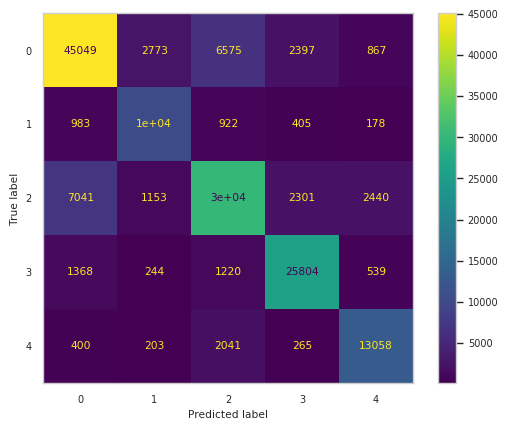

In [27]:
# Confusion matrix (tiles)
cm = confusion_matrix(tiles_oof_pd["class"].values, tiles_oof_pd["oof_class"].values)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES_MAP_LIST)
disp.plot()
plt.grid(False)
plt.show()

## OOF : Image level

In [31]:
def tiles_ensemble(x, func=np.nanmean):
    x = np.stack(x.values) # (N_TILES, N_CLASSES) # Logits
    ret = func(x, axis=0) # Mean across tiles for each class
    return ret

In [32]:
for logit_func in [np.nanmean, np.nanmedian, np.nanmax]:
    images_oof_pd = tiles_oof_pd.groupby("image_id")["oof_logits"].apply(lambda x: tiles_ensemble(x, func=logit_func)).reset_index()
    images_oof_pd["oof_class"] = images_oof_pd["oof_logits"].apply(lambda x: np.argmax(x))
    images_oof_pd["oof_prob"] = images_oof_pd["oof_logits"].apply(lambda x: np.max(softmax(x)))
    # display(images_oof_pd.head())
    train_pd_ = pd.read_csv("./data/train.csv")
    train_pd_["class"] = train_pd_["label"].map(CLASSES_MAP)    
    images_train_pd = train_pd_
    images_train_pd = pd.merge(images_train_pd, images_oof_pd, on=["image_id"], how="inner")
    # display(images_train_pd.head())
    print("Images OOF:", logit_func)
    print("\tBalanced Accuracy: %.3f" % (balanced_accuracy_score(images_train_pd["class"].values, images_train_pd["oof_class"].values)))
    print("\tF1: %.3f" % (f1_score(images_train_pd["class"].values, images_train_pd["oof_class"].values, average="macro", labels=CLASSES_MAP_LIST[0:5])))
    print("\tPrecision: %.3f" % (precision_score(images_train_pd["class"].values, images_train_pd["oof_class"].values, average="macro", labels=CLASSES_MAP_LIST[0:5])))
    print("\tRecall: %s" % (recall_score(images_train_pd["class"].values, images_train_pd["oof_class"].values, average=None, labels=CLASSES_MAP_LIST[0:5]))) 

Images OOF: <function nanmean at 0x7f38803d0b80>
	Balanced Accuracy: 0.862
	F1: 0.856
	Precision: 0.851
	Recall: [0.87387387 0.84782609 0.75806452 0.95959596 0.86956522]
Images OOF: <function nanmedian at 0x7f38803d0e50>
	Balanced Accuracy: 0.860
	F1: 0.848
	Precision: 0.839
	Recall: [0.85585586 0.84782609 0.76612903 0.95959596 0.86956522]
Images OOF: <function nanmax at 0x7f38803d03a0>
	Balanced Accuracy: 0.846
	F1: 0.806
	Precision: 0.785
	Recall: [0.82882883 0.89130435 0.60483871 0.96969697 0.93478261]
